# ResNet: Deep Residual Learning for Image Recognition
By Kaiming He, Xiangyu Zhang, Shaoqing  Ren, Jian Sun


#### The Degradation Problem: 
As we increase the network depth of a deep neural network, accuracy gets saturated. But as we keep increasing the no. of layers, the accuracy starts to decrease, and it is not due to the overfittng.

##### this is the problem ResNet or Residual Network aims to solve

### Residual Block

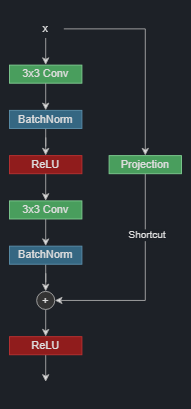

In [1]:
from typing import List, Optional

import torch
from torch import nn 
from labml_helpers.module import Module 

In [2]:
class ShortcutProjection(Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super().__init__()
        #now we can create a 2d convolutional neural network
        self.conv_network = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride = stride)
        
        self.batch_norm= nn.BatchNorm2d(out_channels)#suggested in the paper
        #batch normalisation makes the model less delicate to hyperparameter tuning
         

    def forward(self, x: torch.Tensor):
        return self.batch_norm(self.conv_network(x))
        



In [3]:
class ResidualBlock(Module):
    def __init__(self, in_channel: int, out_channel: int, stride: int):
        super().__init__()

        self.conv_net_1= nn.Conv2d(in_channel,out_channel, kernel_size=3, stride = stride, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.act1 = nn.ReLU()

        self.conv_net_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride = 1, padding =1)
        self.bn2 = nn.BatchNorm2d(out_channel)

        if stride != 1 or in_channel != out_channel:
            self.shortcut = ShortcutProjection(in_channel, out_channel, stride)
        else:
            self.shortcut = nn.Identity()
            
        self.act2 = nn.ReLu()
    def forward(self, x: torch.Tensor):
        shortcut = self.shortcut(x)
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))

        return self.act2(x + shortcut)
        


### Bottleneck Residual Block

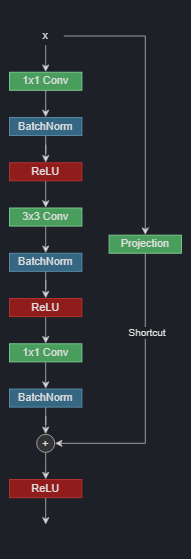

In [4]:
class BottleneckResidualBlock(Module):
    def __init__(self, in_channels: int, bottleneck_channels: int, out_channels: int, stride: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride = 1)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride = 1)
        self.bn3 = nn.BatchNorm2d(bottleneck_channels)
        

        if stride != 1 or in_channels != out_channels:
            self.shortcut = ShortcutProjection(in_channels, out_channels, stride)
        else:
            self.shortcut = nn.Identity()
        self.act3 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        shortcut = self.shortcut(x)
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        return self.act3(x + shortcut)

        






### ResNet Model

The resnet is made of stacked Residual Blocks and Bottleneck Residual Blocks

In [13]:
class ResNetBase(Module):
    def __init__(self, n_blocks: List[int], n_channels: List[int],
                bottleneck: Optional[list[int]]= None,
                img_channels: int =3, first_kernel_size:int= 7):

                

        super().__init__()

        assert len(n_blocks)== len(n_channels)
        assert bottleneck is None or len(bottleneck)==len(n_channels)


        self.conv = nn.Conv2d(img_channels, n_channels[0],kernel_size=first_kernel_size, stride=2, padding=first_kernel_size // 2)
        self.bn = nn.BatchNorm2d(n_channels[0])

        blocks = []
        prev_channels = n_channels[0]

        for i, channels in enumerate(n_channels):

            stride = 2 if len(blocks) == 0 else 1

            if bottleneck in None:
                blocks.append(ResidualBlock(prev_channels, channels, stride =stride))
            else:
                blocks.append(BottleneckResidualBlock(channels, bottleneck[i], channels, stride = 1))

        self.blocks = nn.Sequential(*blocks)
    
    def forward(self, x: torch.Tensor):
        x = self.bn(self.conv(x))
        x = self.blocks(x)

        x = x.view(x.shape[0], x.shape[1], -1)

        return x.mean(dim=-1)

    
